## Contoh 1: Membuat Algoritma k-Means Clustering

In [1]:
# imports
import numpy as np
from typing import Tuple, Dict
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score

# Membuat Algoritma kMeans
class KMeans(object):
    """
    Class to encapsulate the K-Means algorithm
    """

    def __init__(self, K: int=5, n_init: int=20, max_iters: int=300) -> None:
        """
        Initialiser function for a class instance

        Inputs:
            K            -> integer number of clusters to assign
            n_init       -> integer number of times the algorithm will be applied when training
            max_iters    -> maximum number of iterations the algorithm is allowed to run before stopping
        """
        if K <= 0:
            raise ValueError(f'K must be a positive integer, got: {K}')
        if n_init <= 0:
            raise ValueError(f'n_init must be a positive integer, got: {n_init}')
        if max_iters <= 0:
            raise ValueError(f'Input argument max_iters must be a positive integer, got: {max_iters}')
        self.K          = K
        self.n_init     = n_init
        self.centroids  = np.array([])
        self.total_wcss = np.inf
        self.wcss_array = np.array([])
        self.max_iters  = max_iters

    def __del__(self) -> None:
        """
        Destructor function for class instance
        """
        del self.K
        del self.n_init
        del self.centroids
        del self.total_wcss
        del self.wcss_array
        del self.max_iters

    def __assign_samples(self, X : np.array, centroids : np.array) -> np.array:
        """
        Private function to assign samples to clusters

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
            numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        # compute difference between input features & centroids through broadcasting
        differences = X[:, np.newaxis] - centroids[np.newaxis]
        # compute the squared euclidean distance for every (number_samples, K) pairs
        euclid_dist = np.einsum('ijk,ijk->ij', differences, differences)
        # find minimal distance for each sample & return
        return np.argmin(euclid_dist, axis=1)

    def __partition_data(self, X : np.array, cluster_assignment : np.array) -> list:
        """
        Private function to partition input features according to cluster assignment

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        Output:
            list of numpy arrays of centroid for cluster, each array with shape:
            [cluster_number_samples, number_features]
        """
        # join features and cluster assignment
        X_assigned = np.concatenate((X, cluster_assignment.reshape(-1,1)),axis=1)
        # sort on the cluster assignment
        X_assigned = X_assigned[X_assigned[:, -1].argsort()]
        # partition the data based on the cluster assignment & return
        return np.split(X_assigned[:,:-1], np.unique(X_assigned[:, -1], return_index=True)[1][1:])

    def __compute_wcss(self, X : np.array, cluster_assignment : np.array,
                       centroids : np.array) -> Tuple[float, np.array]:
        """
        Private function to compute WCSS over all clusters

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
            centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
            tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute the WCSS for each cluster
        wcss_array = np.array([np.einsum('ij,ij', X_clusters[i] - centroids[i,:],
                                         X_clusters[i] - centroids[i,:]) for i in range(self.K)])
        # return the WCSS per cluster, along with the sum over all clusters
        return (np.sum(wcss_array), wcss_array)

    def __update_centroids(self, X : np.array, cluster_assignment : np.array) -> np.array:
        """
        Private function to update cluster centroids

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        Output:
            numpy array of centroids with shape: [K, number_features]
        """
        X_clusters = self.__partition_data(X, cluster_assignment)
        new_centroids = []
        for i in range(self.K):
            if i < len(X_clusters) and len(X_clusters[i]) > 0:
                new_centroids.append(np.mean(X_clusters[i], axis=0))
            else:
                new_centroids.append(np.random.uniform(np.min(X, axis=0), np.max(X, axis=0)))
        return np.array(new_centroids)

    def fit(self, X : np.array) -> None:
        """
        Training function for the class. Aims to find the optimal centroid values that minimise the WCSS

        Inputs:
            X -> numpy array of input features of assumed  shape [number_samples, number_features]
        """
        # initialise wcss score
        self.total_wcss = np.inf

        # loop over all iterations requested
        for _ in range(self.n_init):

            # initialise centroids
            centroids     = X[np.random.choice(X.shape[0], self.K, replace=False)]
            old_centroids = np.copy(centroids)
            # loop through the K-Means learning algorithm
            centroid_diff = np.ones((self.K))
            iteration     = 0
            while (not np.allclose(centroid_diff, 0)) and iteration < self.max_iters:
                cluster_assignment = self.__assign_samples(X, centroids)
                centroids = self.__update_centroids(X, cluster_assignment)
                if centroids.shape != old_centroids.shape:
                    raise ValueError("Jumlah centroid berubah selama iterasi, periksa pembaruan centroid.")
                centroid_diff = np.linalg.norm(old_centroids - centroids, axis=1)
                iteration += 1
                old_centroids = np.copy(centroids)

            # compute WCSS for the resulting clusters
            total_wcss, wcss_array = self.__compute_wcss(X, cluster_assignment, centroids)
            # check if we have a new optimal centroid configuration?
            if total_wcss < self.total_wcss:
                # if so, update storage objects
                self.total_wcss = total_wcss
                self.wcss_array = wcss_array
                self.centroids  = centroids

    def predict(self, X : np.array) -> None:
        """
        Predict function for the class. Assigns cluster labels to each sample based on proximity to centroids

        Input:
            X -> numpy array of input features of assumed shape [number_samples, number_features]
        Output:
            numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.__assign_samples(X, self.centroids)

    def return_wcss(self) -> Tuple[float, np.array]:
        """
        Public function to return WCSS scores (after training)

        Output:
            tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return (self.total_wcss, self.wcss_array)

    def return_centroids(self) -> np.array:
        """
        Public function to return centroids (after training)

        Output:
            numpy array containing the centroids with shape: [K, number_features]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.centroids

    def get_params(self, deep : bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
            deep -> boolean input parameter
        Outputs:
            Dict -> dictionary of stored class input parameters
        """
        return {'K':self.K,
                'n_init':self.n_init,
                'max_iters':self.max_iters}

# # Memproduksi dataset
X, y, centers = make_blobs(n_samples=9357 , centers=3, n_features=2, return_centers=True, random_state=0)

# # visualise data
# fig, ax    = plt.subplots(figsize=(10,8))
# sc         = ax.scatter(X[:,0],X[:,1],c=y)
# sc_centers = ax.scatter(centers[:,0],centers[:,1],c='r')
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.title('Distribution of Data with True Cluster Assignments')
# ax.legend(*sc.legend_elements(), title='clusters')
# plt.show()


In [2]:
import pandas as pd

# Load the data
data_path = 'D:/Materi Kuliah UNAIR/Semester 5/Pembelajaran Mesin (Praktikum) RK-A2/air+quality/AirQualityUCI.csv'
air_quality_data = pd.read_csv(data_path, sep=';')

# Display the first few rows to understand the structure
print(air_quality_data.head())


         Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

       AH  Unnamed: 15  Unnamed: 16  
0  0,7578         

In [3]:
# Clean up and preprocess the data
# Select relevant columns and rename for easier reference
air_quality_data = air_quality_data[['NMHC(GT)', 'RH']]

# Convert comma decimal to point decimal and drop rows with missing values
air_quality_data = air_quality_data.replace(',', '.', regex=True).astype(float)
air_quality_data.dropna(inplace=True)

# Display the data after preprocessing to confirm changes
air_quality_data.head()

,NMHC(GT),RH
0,150.0,48.9
1,112.0,47.7
2,88.0,54.0
3,80.0,60.0
4,51.0,59.6


In [4]:
# Implementing K-Means clustering on the data with 5 clusters
# Define the features X (only NMHC and RH columns)
X = air_quality_data.values

## Contoh 2: Menerapkan Algoritma k-Means Clustering

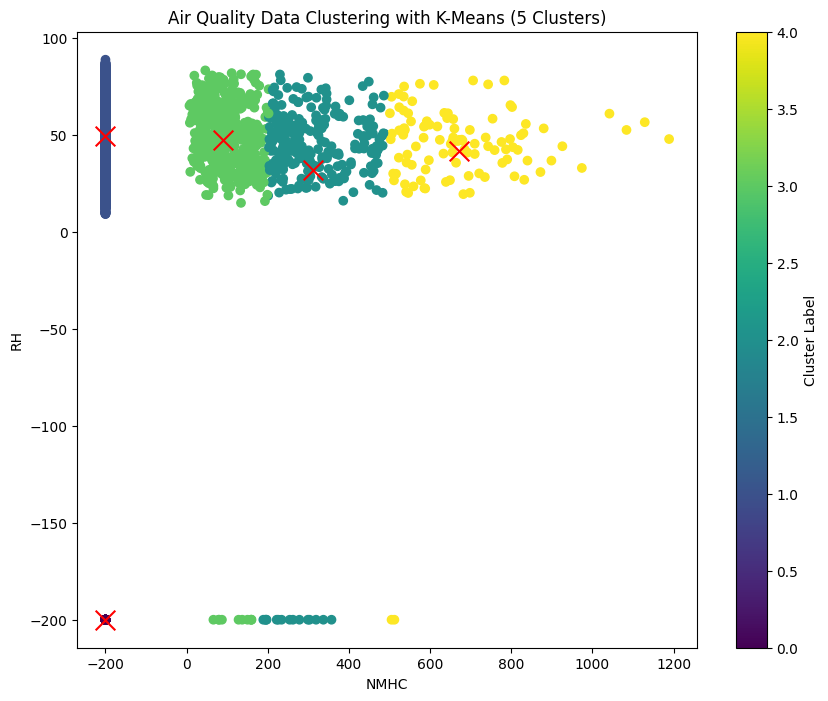

In [5]:
# Buat model KMeans
clt = KMeans(max_iters=300)

# Cocokkan model dengan data
clt.fit(X)

# Dapatkan prediksi
y_pred = clt.predict(X)

# Dapatkan prediksi sentroid
centers_pred = clt.return_centroids()

# Visualisasikan prediksi
fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', marker='o')
sc_centers = ax.scatter(centers_pred[:, 0], centers_pred[:, 1], c='red', marker='x', s=200)
plt.xlabel('NMHC')
plt.ylabel('RH')
plt.title('Air Quality Data Clustering with K-Means (5 Clusters)')
plt.colorbar(sc, label='Cluster Label')
plt.show()


## Contoh 3: Menilai Performa Algoritma k-Means Clustering

In [6]:
from sklearn.metrics import mean_absolute_error, silhouette_score

# Mendapatkan nilai cluster errors
clt.return_wcss()

# Seberapa akurat estimasi sentroid yang dihasilkan?
print(f'The mean absolute error between the calculated centroids and predicted centroids is: {mean_absolute_error(centers_pred, clt.centroids)}')

# Kalibrasikan pelabelan (if needed)
# (Kalibrasi ini tidak diperlukan jika tidak ada label asli)

# Evaluasi kualitas klasterisasi menggunakan Silhouette Score
silhouette_avg = silhouette_score(X, y_pred)
print(f'Silhouette Score: {silhouette_avg:.4f}')


# Kalibrasikan pelabelan (if needed)
idx_0         = y_pred == 0
idx_1         = y_pred == 1
idx_2         = y_pred == 2
y_pred[idx_0] = 2
y_pred[idx_1] = 0
y_pred[idx_2] = 1

# Seberapa akurat penempatan klasterisasi yang dihasilkan? 
acc = accuracy_score(y,y_pred)
pre = precision_score(y,y_pred,average='weighted')
rec = recall_score(y,y_pred,average='weighted')
f1  = f1_score(y,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')


The mean absolute error between the calculated centroids and predicted centroids is: 0.0
Silhouette Score: 0.8872
Accuracy score: 0.3126
Precision score: 0.3463
Recall score: 0.3126
F1 score: 0.2022


c:\Users\JuhenFW\VSCODE\myenv2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


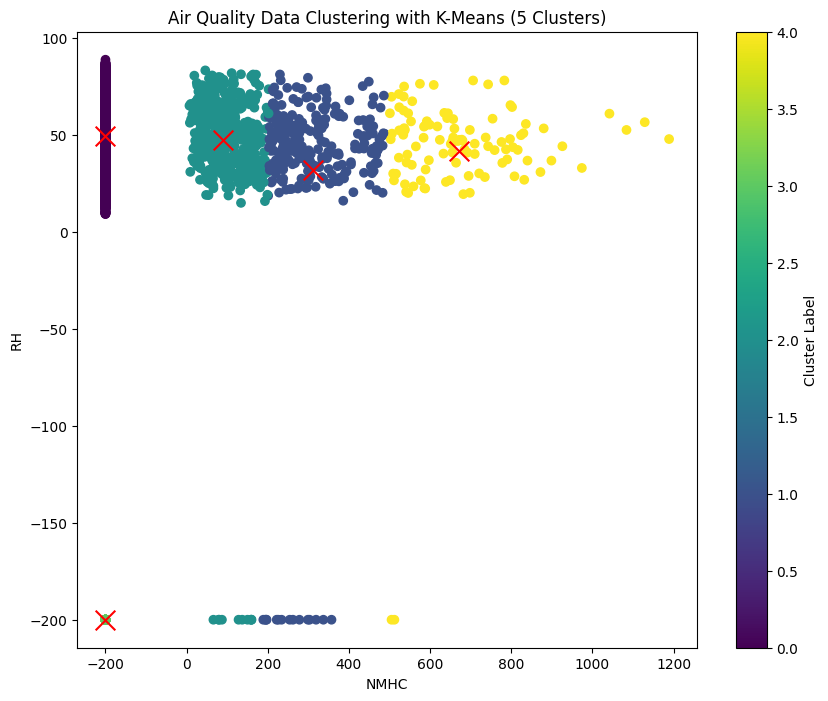

Mean Absolute Error (MAE) across clusters: 30.5750
Silhouette Score: 0.8872
Accuracy (Scikit-Learn KMeans): 0.3204
Precision (Scikit-Learn KMeans): 0.3452
Recall (Scikit-Learn KMeans): 0.3204
F1 Score (Scikit-Learn KMeans): 0.2141


c:\Users\JuhenFW\VSCODE\myenv2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
from sklearn.cluster import KMeans

# Buat model KMeans Scikit-Learn
sklearn_clt = KMeans(n_clusters=5, max_iter=300, random_state=0)
sklearn_clt.fit(X)

# Prediksi hasil klasterisasi
y_pred_sklearn = sklearn_clt.predict(X)
centers_pred_sklearn = sklearn_clt.cluster_centers_

# Visualisasikan prediksi
fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(X[:, 0], X[:, 1], c=y_pred_sklearn, cmap='viridis', marker='o')
sc_centers = ax.scatter(centers_pred_sklearn[:, 0], centers_pred_sklearn[:, 1], c='red', marker='x', s=200)
plt.xlabel('NMHC')
plt.ylabel('RH')
plt.title('Air Quality Data Clustering with K-Means (5 Clusters)')
plt.colorbar(sc, label='Cluster Label')
plt.show()

# Mendapatkan nilai cluster errors
clt.return_wcss()

# Menghitung jarak setiap titik data ke centroid klasternya
cluster_assignment = clt.predict(X)
mae_values = []

for i in range(clt.K):
    # Ambil titik data yang berada dalam cluster i
    cluster_points = X[cluster_assignment == i]
    # Hitung jarak setiap titik dalam cluster ini ke centroid-nya
    centroid = centers_pred[i]
    mae_cluster = mean_absolute_error(cluster_points, np.tile(centroid, (cluster_points.shape[0], 1)))
    mae_values.append(mae_cluster)

# Menghitung rata-rata MAE di seluruh cluster
overall_mae = np.mean(mae_values)
print(f"Mean Absolute Error (MAE) across clusters: {overall_mae:.4f}")

# Kalibrasikan pelabelan (if needed)
# (Kalibrasi ini tidak diperlukan jika tidak ada label asli)

# Evaluasi kualitas klasterisasi menggunakan Silhouette Score
silhouette_avg = silhouette_score(X, y_pred)
print(f'Silhouette Score: {silhouette_avg:.4f}')

# Evaluasi performa
# mae_sklearn = mean_absolute_error(centers, centers_pred_sklearn)
acc_sklearn = accuracy_score(y, y_pred_sklearn)
pre_sklearn = precision_score(y, y_pred_sklearn, average='weighted')
rec_sklearn = recall_score(y, y_pred_sklearn, average='weighted')
f1_sklearn = f1_score(y, y_pred_sklearn, average='weighted')

# print(f"MAE (Scikit-Learn KMeans): {mae_sklearn:.4f}")
print(f"Accuracy (Scikit-Learn KMeans): {acc_sklearn:.4f}")
print(f"Precision (Scikit-Learn KMeans): {pre_sklearn:.4f}")
print(f"Recall (Scikit-Learn KMeans): {rec_sklearn:.4f}")
print(f"F1 Score (Scikit-Learn KMeans): {f1_sklearn:.4f}")
